# Rudiments of Natural Language Processing: Attention

This is the third part of the NLP workshop at the Center for Machine Learning. In this notebook we extend the previously created model with an attention mechanism. We do the following:

*   Gather some prerequisites
*   Restore previous datapipes, vocabulary, and model
*   Implement the attention mechanism
*   Implement multi-head attention
*   Train and evaluate models with attention
*   Inspect the attention weights



## Prerequisites

Before you even start go to the menu above and make sure that your execution environment uses the GPU. Otherwise the model will train very slowly. If you change the environment later you will need to rerun the notebook from the begining. Now install the missing dependencies:

In [ ]:
!pip install portalocker

Import the necessary modules:

In [ ]:
import google.colab as colab
import matplotlib.pyplot as plt
import pickle
import torch
import torchdata
import torchtext

In the first notebook we saved some data in your home directory on the google drive. To read these data mount your drive:

In [ ]:
colab.drive.mount('/content/drive')

Your home directory is now mounted as `drive/MyDrive`. Check it by listing its contents:

In [ ]:
!ls drive/MyDrive/

You should see the files `vocab.pkl`, `train_data.csv` and `valid_data.csv`. If not run the first notebook to produce them.

## Datapipes, vocabulary, and model

In the previous notebook we created datapipes that read the training and validation data. Create them again:

In [ ]:
def decode(sample):
    label0, *index1 = sample
    label0 = float(label0)
    index1 = torch.tensor([int(index0) for index0 in index1])
    return label0, index1

def collate(batch):
    label1, index2 = zip(*batch)
    label1 = torch.tensor(label1)
    index2 = torch.nn.utils.rnn.pad_sequence(index2, padding_value = 0, batch_first = True)
    return label1, index2

train_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/train_data.csv'])
train_pipe = train_pipe.parse_csv()
train_pipe = train_pipe.map(decode)
train_pipe = train_pipe.shuffle(buffer_size = 16384)
train_pipe = train_pipe.batch(64)
train_pipe = train_pipe.collate(collate)

valid_pipe = torchdata.datapipes.iter.FileOpener(['drive/MyDrive/valid_data.csv'])
valid_pipe = valid_pipe.parse_csv()
valid_pipe = valid_pipe.map(decode)
valid_pipe = valid_pipe.batch(64)
valid_pipe = valid_pipe.collate(collate)

We also created a vocabulary and saved it to your google drive. Load it:

In [ ]:
with open('drive/MyDrive/vocab.pkl', 'rb') as stream:
    vocab = pickle.load(stream)

Read the vocabulary size and set it as the number of unique words or word indices:

In [ ]:
indices = len(vocab)

Set the number of embedding features to the previous value of four:

In [ ]:
features = 4

In the previous notebook we implemented the following model:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1)        #(samples, features)
        logit = self.classifier(feature) #(samples, 1)
        logit = logit.flatten()          #(samples)
        return logit

Instantiate it:

In [ ]:
model = Model()

Just as a reminder print the input and output shapes for a few batches:

In [ ]:
for truth_label, index in train_pipe.header(10):
    print(index.size())
    logit = model(index)
    print(logit.size())
    print()

## Attention

Our simple model averages the embedding features of all the words in a review. We will now replace the arithmetic mean with a weighted average. The weights will be learned during training to pay more attention to important words. Look at the previous simple model:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1)        #(samples, features)
        logit = self.classifier(feature) #(samples, 1)
        logit = logit.flatten()          #(samples)
        return logit

Averaging the features along the `frames` axis removes this dimension by default. Now force the mean operation to keep it:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):            #(samples, frames)
        feature = self.encoder(index)    #(samples, frames, features)
        feature = feature.mean(1, True)  #(samples, 1, features)
        logit = self.classifier(feature) #(samples, 1, 1)
        logit = logit.flatten()          #(samples)
        return logit

The `frames` dimension is now shrinked to the size of one. The classifier layer works only on the `features` axis and also reduces its size to one. The singleton dimensions created in this way are then removed by the flatten operation. Now read the dimensions of the incoming batch and replace the arithmetic average with a weighted mean with equal weights. Implement the weighting as matrix multiplication:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):                                 #(samples, frames)
        feature = self.encoder(index)                         #(samples, frames, features)
        samples, frames, features = feature.size()
        weight = torch.full((samples, 1, frames), 1 / frames) #(samples, 1, frames)
        feature = weight @ feature                            #(samples, 1, features)
        logit = self.classifier(feature)                      #(samples, 1, 1)
        logit = logit.flatten()                               #(samples)
        return logit

Note that the weights have a `samples` dimension and will soon be different for each sample in the batch. The matrix multiplication works separately for each sample and actually multiplies two-dimensional matrices. Equal weights still yield the artihmetic mean but formally our model already calculates a weighted average. Move this average to a separate attention module:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
    def forward(self, feature):                               #(samples, frames, features)
        samples, frames, features = feature.size()
        weight = torch.full((samples, 1, frames), 1 / frames) #(samples, 1, frames)
        feature = weight @ feature                            #(samples, 1, features)
        return feature

class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):             #(samples, frames)
        feature = self.encoder(index)     #(samples, frames, features)
        feature = self.attention(feature) #(samples, 1, features)
        logit = self.classifier(feature)  #(samples, 1, 1)
        logit = logit.flatten()           #(samples)
        return logit

From now on we will work only on the attention module:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
    def forward(self, feature):                               #(samples, frames, features)
        samples, frames, features = feature.size()
        weight = torch.full((samples, 1, frames), 1 / frames) #(samples, 1, frames)
        feature = weight @ feature                            #(samples, 1, features)
        return feature

Note that weights must be positive and sum up to one along the `frames` axis. So they can be produced by the softmax function applied along this axis. In the context of attention the softmax inputs are called energies and have the same shape as the weights. Use zero energies for now:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
    def forward(self, feature):                         #(samples, frames, features)
        samples, frames, features = feature.size()
        energy = torch.zeros((samples, 1, frames))      #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ feature                      #(samples, 1, features)
        return feature

With zero energies the softmax yields equal weights so the model still calculates the arithmetic mean. This will change now. Now the energies will be scalar products of the embedding features with a single vector called query. It is convenient to give the query vector two singleton dimensions and calculate the scalar products as matrix multiplication:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.empty(1, 1, features)
    def forward(self, feature):                         #(samples, frames, features)
        energy = self.query @ feature.transpose(1, 2)   #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ feature                      #(samples, 1, features)
        return feature

The new matrix multiplication broadcasts the first dimension of the query vector as if there was a separate but equal query vector for each sample in the batch. Then for each sample scalar products of the query vector with all the feature vectors in this sample are calculated. These scalar products are larger or smaller for frames with features similar or different from the query vector respectively. Such scalar products become the energies which are fed to the softmax function and converted to weights. Now the weighted average indeed pays more attention to frames that are in a sense similar to the query vector. Till now the query vector had some undefined values but we will now properly initialize it and make it a trainable parameter of the model:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        torch.nn.init.xavier_normal_(self.query)
    def forward(self, feature):                         #(samples, frames, features)
        energy = self.query @ feature.transpose(1, 2)   #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ feature                      #(samples, 1, features)
        return feature

Now the query vector will be learned from data during training together with all the remaining parameters of the model. This is the basic version of the attention module that could already be used. But we will stll enrich it a bit. Note that the input features are first used to calculate the energies and then to calculate the output features by weighting. We usually say that they are first used as keys and then as values. To make it more explicit introduce key and value vectors just equal to the input features:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        torch.nn.init.xavier_normal_(self.query)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature                                   #(samples, frames, features)
        value = feature                                 #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ value                        #(samples, 1, features)
        return feature

We now say that the key and value vectors need not be exactly equal to the input features but may be multiplied by some square matrices. These matrices will also be trainable parameters of the model:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ value                        #(samples, 1, features)
        return feature

This is called a query-key-value form of the attention mechanism. Let us now use it in our model instead of the initial arithmetic mean:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):             #(samples, frames)
        feature = self.encoder(index)     #(samples, frames, features)
        feature = self.attention(feature) #(samples, 1, features)
        logit = self.classifier(feature)  #(samples, 1, 1)
        logit = logit.flatten()           #(samples)
        return logit

Note that apart from the new attention the model has not changed. Instantiate it:

In [ ]:
model = Model().cuda()

Train it:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.506 0.500
    1 0.657 0.538
    2 0.796 0.749
    3 0.837 0.813
    4 0.856 0.838
    5 0.871 0.850
    6 0.883 0.861
    7 0.891 0.871
    8 0.898 0.876
    9 0.905 0.880
   10 0.911 0.882
   11 0.917 0.882
   12 0.923 0.885
   13 0.926 0.886
   14 0.929 0.886
   15 0.933 0.887
   16 0.938 0.886
   17 0.942 0.885
   18 0.946 0.886
   19 0.949 0.882
   20 0.952 0.884
   21 0.956 0.885
   22 0.957 0.881
   23 0.961 0.881
   24 0.964 0.881
   25 0.966 0.880
   26 0.969 0.880
   27 0.971 0.880
   28 0.974 0.879
   29 0.976 0.878
   30 0.978 0.875
   31 0.981 0.874
   32 0.982 0.874
   33 0.984 0.870
   34 0.985 0.872
   35 0.987 0.869
   36 0.988 0.868
   37 0.990 0.864
   38 0.991 0.865
   39 0.992 0.860
   40 0.993 0.859
   41 0.994 0.860
   42 0.995 0.858
   43 0.996 0.856
   44 0.997 0.856
   45 0.997 0.854
   46 0.998 0.850
   47 0.998 0.852
   48 0.999 0.851
   49 0.999 0.849
   50 0.999 0.847
   51 0.999 0.847
   52 1.000 0.845
   53 1.000 0.845
   54 1.000 0.840
   55 1.00

Plot the training and validation accuracies:

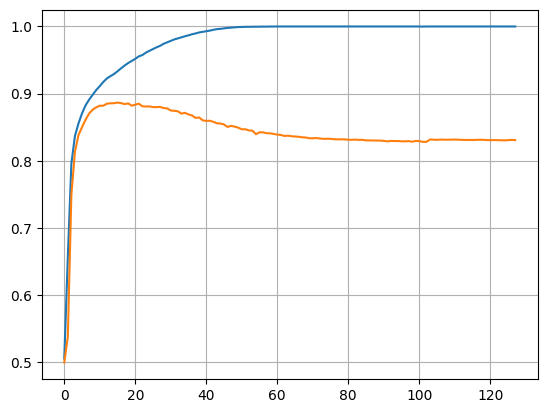

In [ ]:
epoch, train_accuracy, valid_accuracy = zip(*history)

plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

Compare these results against the simple model with arithmetic mean. The training accuracy achieves 100% much faster now which means that the attention model can better reproduce the data. But the validation accuracy is lower than previously. This is because more complex models exhibit more overfitting. To improve the validation accuracy more training data would be required.

## Attention weights

Let us now inspect the attention weights learned during training. Modify the attention module so that it returns not only the output features but also the weights:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ value                        #(samples, 1, features)
        return feature, weight

Also modify the model so that it reads the weights from the attention module and returns them as well:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):                     #(samples, frames)
        feature = self.encoder(index)             #(samples, frames, features)
        feature, weight = self.attention(feature) #(samples, 1, features)
        logit = self.classifier(feature)          #(samples, 1, 1)
        logit = logit.flatten()                   #(samples)
        return logit, weight

Instantiate the model and read its parameters from disk:

In [ ]:
model = Model()
model.load_state_dict(torch.load('model.pt'))

In this way we load the parameters from the epoch when the model performed best on the validation data. Get the list of unique words in the vocabulary:

In [ ]:
itos = vocab.get_itos()

Iterate through some batches of the validation data. From each batch take the first sample and display the words together with their weights assigned by the attention mechanism:

In [ ]:
for truth_label1, index2 in valid_pipe.header(10):
    colab.output.clear()
    logit1, weight3 = model(index2)
    for index0, weight0 in zip(index2[0], weight3[0, 0]):
        print('%18s %5.3f' % (itos[index0], weight0))
    input()

                as 0.001
               you 0.002
               may 0.004
              know 0.003
               the 0.000
           subject 0.002
              here 0.001
               was 0.000
                to 0.000
               ask 0.004
            eleven 0.004
         directors 0.001
              from 0.001
               all 0.003
              over 0.000
               the 0.000
             world 0.004
                to 0.000
              make 0.003
              each 0.000
                 a 0.000
             short 0.001
             movie 0.001
                of 0.000
           minutes 0.010
           seconds 0.000
               and 0.000
               one 0.000
             frame 0.002
                we 0.000
              have 0.001
              here 0.001
             <unk> 0.002
             <unk> 0.002
              iran 0.003
              what 0.000
            afghan 0.001
           refugee 0.003
              kids 0.000
               can 0.003


Note that high weights are assigned to emotional words like *excellent* or *boring* which is expected. But sometimes relatively high weights are also assigned to rather neutral words like *wtc* which is rather surprising. This occurs when such a neutral word appears only in positive or negative training reviews. Then the model thinks that it is important. This is one cause of the mentioned overfitting.

## Multi-head attention

We would expect that the attention mechanism assigns low weights to neutral words and high weights to strongly emotional words both negative and positive. But the energies or scalar products are high for words with embedding features similar to the query vector. It is hard to expect that the query vector can be similar to features of both negative and positive words. Maybe there should be two query vectors and two sets of attention weights. This observation leads to the idea of multi-head attention that we will now implement. Start with the hitherto query-key-value attention:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                         #(samples, frames, features)
        key = feature @ self.weightK                    #(samples, frames, features)
        value = feature @ self.weightV                  #(samples, frames, features)
        energy = self.query @ key.transpose(1, 2)       #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2) #(samples, 1, frames)
        feature = weight @ value                        #(samples, 1, features)
        return feature

The ordinary matrix-multiplication operator is not sufficient to implement multi-head attention. So first rewrite the same attention module in terms of tensor product and Einstein summation:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features))
        self.weightK = torch.nn.Parameter(torch.empty(features, features))
        self.weightV = torch.nn.Parameter(torch.empty(features, features))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                                #(samples, frames, features)
        key = torch.tensordot(feature, self.weightK, 1)        #(samples, frames, features)
        value = torch.tensordot(feature, self.weightV, 1)      #(samples, frames, features)
        energy = torch.einsum('ijk,ilk->ijl', self.query, key) #(samples, 1, frames)
        weight = torch.nn.functional.softmax(energy, 2)        #(samples, 1, frames)
        feature = torch.einsum('ijk,ikl->ijl', weight, value)  #(samples, 1, features)
        return feature

In principle a multi-head attention is just a set of several attention modules each with its own parameters. Each of these modules is called a head and there may be arbitrarily many heads. For our purposes set the number of heads to two:

In [ ]:
heads = 2

Instead of using many attention modules we will add a `heads` dimension to each tensor in one module:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features, heads))
        self.weightK = torch.nn.Parameter(torch.empty(features, features, heads))
        self.weightV = torch.nn.Parameter(torch.empty(features, features, heads))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                                   #(samples, frames, features)
        key = torch.tensordot(feature, self.weightK, 1)           #(samples, frames, features, heads)
        value = torch.tensordot(feature, self.weightV, 1)         #(samples, frames, features, heads)
        energy = torch.einsum('ijkm,ilkm->ijlm', self.query, key) #(samples, 1, frames, heads)
        weight = torch.nn.functional.softmax(energy, 2)           #(samples, 1, frames, heads)
        feature = torch.einsum('ijkm,iklm->ijlm', weight, value)  #(samples, 1, features, heads)
        return feature

Each head gives a set of output features that must be somehow aggregated back to one set. It can be done by just averaging the features over the heads:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features, heads))
        self.weightK = torch.nn.Parameter(torch.empty(features, features, heads))
        self.weightV = torch.nn.Parameter(torch.empty(features, features, heads))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
    def forward(self, feature):                                   #(samples, frames, features)
        key = torch.tensordot(feature, self.weightK, 1)           #(samples, frames, features, heads)
        value = torch.tensordot(feature, self.weightV, 1)         #(samples, frames, features, heads)
        energy = torch.einsum('ijkm,ilkm->ijlm', self.query, key) #(samples, 1, frames, heads)
        weight = torch.nn.functional.softmax(energy, 2)           #(samples, 1, frames, heads)
        feature = torch.einsum('ijkm,iklm->ijlm', weight, value)  #(samples, 1, features, heads)
        feature = feature.mean(3)                                 #(samples, 1, features)
        return feature

A better way is to catenate the features from all heads and then pass them through a linear layer that will again produce one set of features:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features, heads))
        self.weightK = torch.nn.Parameter(torch.empty(features, features, heads))
        self.weightV = torch.nn.Parameter(torch.empty(features, features, heads))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
        self.linear = torch.nn.Linear(features * heads, features)
    def forward(self, feature):                                   #(samples, frames, features)
        key = torch.tensordot(feature, self.weightK, 1)           #(samples, frames, features, heads)
        value = torch.tensordot(feature, self.weightV, 1)         #(samples, frames, features, heads)
        energy = torch.einsum('ijkm,ilkm->ijlm', self.query, key) #(samples, 1, frames, heads)
        weight = torch.nn.functional.softmax(energy, 2)           #(samples, 1, frames, heads)
        feature = torch.einsum('ijkm,iklm->ijlm', weight, value)  #(samples, 1, features, heads)
        feature = feature.flatten(2)                              #(samples, 1, features * heads)
        feature = self.linear(feature)                            #(samples, 1, features)
        return feature

The final output from this multi-head attention has the same shape as previously. So substitute this attention into the previous model:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):             #(samples, frames)
        feature = self.encoder(index)     #(samples, frames, features)
        feature = self.attention(feature) #(samples, 1, features)
        logit = self.classifier(feature)  #(samples, 1, 1)
        logit = logit.flatten()           #(samples)
        return logit

Instantiate the model:

In [ ]:
model = Model().cuda()

Train it:

In [ ]:
history = list()
optimizer = torch.optim.Adam(model.parameters())
max_valid_accuracy = torch.tensor(0.).cuda()
for epoch in range(128):
    valid_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in valid_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        valid_accuracy += hit.count_nonzero()
        samples += hit.numel()
    valid_accuracy = valid_accuracy / samples
    if max_valid_accuracy.lt(valid_accuracy):
        max_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'model.pt')
    train_accuracy = torch.tensor(0).cuda()
    samples = torch.tensor(0).cuda()
    for truth_label, index in train_pipe:
        truth_label, index = truth_label.cuda(), index.cuda()
        logit = model(index)
        model_label = logit.gt(0).float()
        hit = model_label.eq(truth_label)
        train_accuracy += hit.count_nonzero()
        samples += hit.numel()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, truth_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_accuracy / samples
    history.append((epoch, train_accuracy.item(), valid_accuracy.item()))
    print('%5i %5.3f %5.3f' % (epoch, train_accuracy, valid_accuracy))

    0 0.542 0.507
    1 0.750 0.636
    2 0.841 0.806
    3 0.867 0.844
    4 0.882 0.859
    5 0.895 0.868
    6 0.903 0.874
    7 0.910 0.878
    8 0.917 0.883
    9 0.923 0.883
   10 0.927 0.887
   11 0.933 0.884
   12 0.936 0.887
   13 0.941 0.888
   14 0.945 0.890
   15 0.951 0.890
   16 0.954 0.889
   17 0.958 0.890
   18 0.961 0.890
   19 0.965 0.886
   20 0.969 0.887
   21 0.972 0.882
   22 0.975 0.883
   23 0.977 0.883
   24 0.980 0.882
   25 0.983 0.881
   26 0.986 0.877
   27 0.987 0.878
   28 0.989 0.876
   29 0.990 0.876
   30 0.992 0.873
   31 0.993 0.872
   32 0.995 0.869
   33 0.996 0.869
   34 0.997 0.866
   35 0.998 0.866
   36 0.998 0.863
   37 0.999 0.862
   38 0.999 0.860
   39 0.999 0.859
   40 0.999 0.859
   41 1.000 0.856
   42 0.999 0.854
   43 1.000 0.856
   44 1.000 0.854
   45 1.000 0.854
   46 1.000 0.854
   47 1.000 0.854
   48 1.000 0.854
   49 1.000 0.854
   50 1.000 0.853
   51 1.000 0.850
   52 1.000 0.853
   53 1.000 0.854
   54 1.000 0.853
   55 1.00

Plot the accuracies:

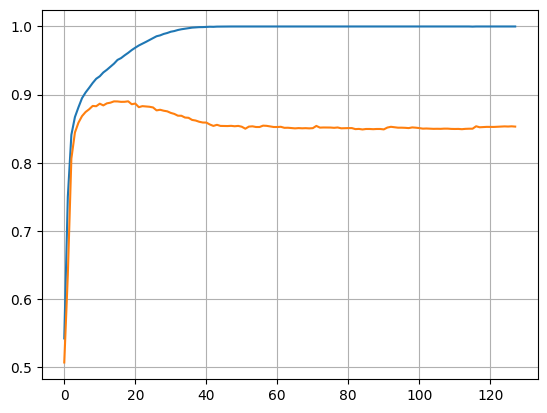

In [ ]:
epoch, train_accuracy, valid_accuracy = zip(*history)

plt.grid()
plt.plot(epoch, train_accuracy)
plt.plot(epoch, valid_accuracy)

The validation accuracy with two-head attention seems slightly higher than with one-head attention. To inspect the weights create an attention module that returns them as previously:

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.query = torch.nn.Parameter(torch.empty(1, 1, features, heads))
        self.weightK = torch.nn.Parameter(torch.empty(features, features, heads))
        self.weightV = torch.nn.Parameter(torch.empty(features, features, heads))
        torch.nn.init.xavier_normal_(self.query)
        torch.nn.init.xavier_normal_(self.weightK)
        torch.nn.init.xavier_normal_(self.weightV)
        self.linear = torch.nn.Linear(features * heads, features)
    def forward(self, feature):                                   #(samples, frames, features)
        key = torch.tensordot(feature, self.weightK, 1)           #(samples, frames, features, heads)
        value = torch.tensordot(feature, self.weightV, 1)         #(samples, frames, features, heads)
        energy = torch.einsum('ijkm,ilkm->ijlm', self.query, key) #(samples, 1, frames, heads)
        weight = torch.nn.functional.softmax(energy, 2)           #(samples, 1, frames, heads)
        feature = torch.einsum('ijkm,iklm->ijlm', weight, value)  #(samples, 1, features, heads)
        feature = feature.flatten(2)                              #(samples, 1, features * heads)
        feature = self.linear(feature)                            #(samples, 1, features)
        return feature, weight

Create the corresponding model:

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.encoder = torch.nn.Embedding(indices, features)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(features, 1)
    def forward(self, index):                     #(samples, frames)
        feature = self.encoder(index)             #(samples, frames, features)
        feature, weight = self.attention(feature) #(samples, 1, features)
        logit = self.classifier(feature)          #(samples, 1, 1)
        logit = logit.flatten()                   #(samples)
        return logit, weight

Instantiate the model and load the best parameters:

In [ ]:
model = Model()
model.load_state_dict(torch.load('model.pt'))

Iterate through some batches of the validation data. From each batch take the first sample and display the words together with their weights assigned by the attention mechanism:

In [ ]:
for truth_label1, index2 in valid_pipe.header(10):
    colab.output.clear()
    logit1, weight3 = model(index2)
    for index0, weight1 in zip(index2[0], weight3[0, 0]):
        print('%18s %5.3f %5.3f' % (itos[index0], weight1[0], weight1[1]))
    input()

                as 0.001 0.001
               you 0.005 0.007
               may 0.000 0.000
              know 0.000 0.000
               the 0.000 0.001
           subject 0.002 0.000
              here 0.000 0.001
               was 0.000 0.002
                to 0.001 0.001
               ask 0.000 0.001
            eleven 0.003 0.000
         directors 0.001 0.010
              from 0.000 0.000
               all 0.001 0.000
              over 0.001 0.003
               the 0.000 0.001
             world 0.004 0.001
                to 0.001 0.001
              make 0.003 0.005
              each 0.000 0.000
                 a 0.001 0.000
             short 0.001 0.002
             movie 0.000 0.000
                of 0.001 0.002
           minutes 0.000 0.020
           seconds 0.001 0.000
               and 0.000 0.001
               one 0.001 0.001
             frame 0.001 0.000
                we 0.002 0.000
              have 0.002 0.002
              here 0.000 0.001
        

It is hard to say whether the two attention heads indeed respond to negative and positive words but at least they have learned something different and thus enriched the model. Now proceed to the next notebook to replace attention with self-attention and introduce the transformer architecture.